# 03. Generating Sets of Chemicals with the ChemicalMixtureCreator class

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np

In [3]:
import os
import sys
sys.path.append('../..')

In [4]:
import pylab as plt
%matplotlib inline

In [5]:
from vimms.Chemicals import ChemicalMixtureCreator
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController
from vimms.Environment import Environment
from vimms.Common import POSITIVE, set_log_level_warning, set_log_level_debug

## Introduction

The `ChemicalMixtureCreator` offers the most simple method for creating chemical datasets for simulation allowing the generation of a dataset of chemicals in just a few lines of python.

The class requires several other classes to run:

- A class that can generate _formulas_
- A class that can generate RT and intensity for formulas
- A class that can generate chromatograms for formulas
- A class that can generate MS2 spectra for formulas

### `FormulaSampler`

An instance of a class extending `FormulaSampler` must be provided. This samples the chemicals that will appear. Note that `Formula` is abused here: in some cases the result is a chemical formula, but in others, just an m/z. Which it does has implications for the data generated (see below).  Currently, the following options are available:

- `DatabaseFormulaSampler`: samples formulas from a database provided. Code is given to generate from HMDB
- `UniformMZFormulaSampler`: samples _formulas_ (just masses) uniformly in an m/z range
- `PickEverythingFormulaSampler`: samples all formulas from a database
- `EvenMZFormulaSampler`: creates evenly spaced m/z, starting at 100Da, with 100 Da spacing. Mainly used for test cases.
- `MZMLFormulaSampler`: samples m/z values from a histogram of m/z taken from a user supplied mzML file

Examples of creating some of these objects

#### `DatabaseFormulaSampler`

In [6]:
from vimms.ChemicalSamplers import DatabaseFormulaSampler
from vimms.Common import load_obj

In [7]:
data_dir = os.path.abspath(os.path.join(os.getcwd(),'..','..','tests','fixtures'))
HMDB = os.path.join(data_dir,'hmdb_compounds.p')
hmdb = load_obj(HMDB)

In [8]:
compound_file = 'hmdb_compounds.p'
try:
    hmdb_compounds = load_obj(compound_file)
except FileNotFoundError:
    
    # download the entire HMDB metabolite database and extract chemicals from it
    # url = 'http://www.hmdb.ca/system/downloads/current/hmdb_metabolites.zip'
    # out_file = download_file(url)
    # compounds = extract_hmdb_metabolite(out_file, delete=True)
    # save_obj(compounds, compound_file)
    
    # above could be quite slow slow, so download a pre-processed result instead
    url = 'https://github.com/glasgowcompbio/vimms-data/raw/main/hmdb_compounds.p'
    download_file(url, compound_file)
    hmdb_compounds = load_obj(compound_file)

2022-02-24 16:33:57.856 | DEBUG    | vimms.ChemicalSamplers:sample:73 - 73822 unique formulas in filtered database
2022-02-24 16:33:57.856 | DEBUG    | vimms.ChemicalSamplers:sample:79 - Sampled formulas


(array([ 62.,  62.,  87.,  74.,  45.,  51.,  75., 137., 233., 174.]),
 array([104.06597108, 191.53613807, 279.00630506, 366.47647206,
        453.94663905, 541.41680604, 628.88697304, 716.35714003,
        803.82730702, 891.29747402, 978.76764101]),
 <BarContainer object of 10 artists>)

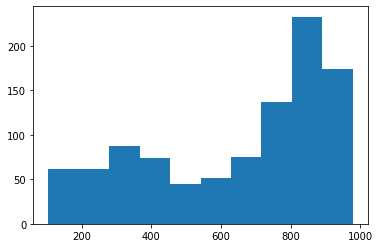

In [9]:
# create a database formula sampler that will sample from HMDB with m/z between 100 and 1000
df = DatabaseFormulaSampler(hmdb_compounds, min_mz=100, max_mz=1000)
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

(array([ 85.,  94., 102., 106., 105., 100.,  97., 105., 106., 100.]),
 array([100.4724363 , 140.38524556, 180.29805482, 220.21086408,
        260.12367334, 300.0364826 , 339.94929186, 379.86210111,
        419.77491037, 459.68771963, 499.60052889]),
 <BarContainer object of 10 artists>)

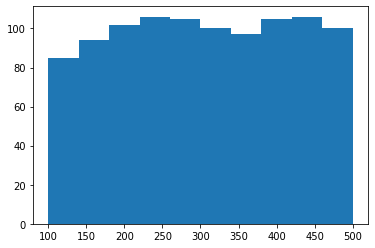

In [10]:
from vimms.ChemicalSamplers import UniformMZFormulaSampler
# create a formula sampler that samples masses uniformly between 100 and 500
df = UniformMZFormulaSampler(min_mz=100, max_mz=500)
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

2022-02-24 16:33:58.751 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 364 scans


(array([116., 240., 432., 180.,  25.,   1.,   4.,   0.,   1.,   1.]),
 array([ 73.76019879, 140.16717238, 206.57414598, 272.98111957,
        339.38809316, 405.79506675, 472.20204034, 538.60901393,
        605.01598753, 671.42296112, 737.82993471]),
 <BarContainer object of 10 artists>)

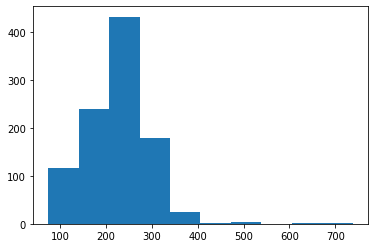

In [11]:
from vimms.ChemicalSamplers import MZMLFormulaSampler
MZML = os.path.join(data_dir, 'small_mzml.mzML')
df = MZMLFormulaSampler(MZML)
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

### `RTAndIntensitySampler`

Passing an instance of this is optional. If nothing is passed, it defaults to `UniformRTAndIntensitySampler`

Available:

- `UniformRTAndIntensitySampler`: samples RT and intensity independently from uniform distributions (note that intensity is unifrom in log space)
- `MZMLRTandIntensitySampler`: samples RT and intensity independely from histograms produced from an mzML file

Examples:

#### `UniformRTAndIntensitySampler`

(array([669., 100.,  60.,  32.,  20.,  32.,  25.,  23.,  17.,  22.]),
 array([7.45916588e+00, 8.15014228e+02, 1.62256929e+03, 2.43012435e+03,
        3.23767941e+03, 4.04523448e+03, 4.85278954e+03, 5.66034460e+03,
        6.46789966e+03, 7.27545473e+03, 8.08300979e+03]),
 <BarContainer object of 10 artists>)

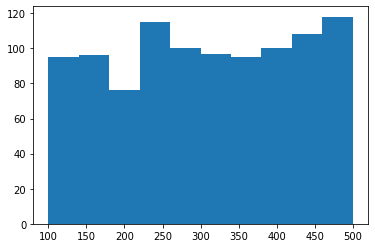

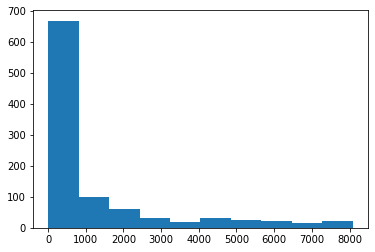

In [12]:
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler
ri = UniformRTAndIntensitySampler(min_rt=100, max_rt=500, min_log_intensity=2, max_log_intensity=9)
rt_list = []
intensity_list = []
for i in range(1000):
    a,b = ri.sample(None) #argument is a formula, but is ignored at the moment
    rt_list.append(a)
    intensity_list.append(b)
plt.figure()
plt.hist(rt_list)
plt.figure()
plt.hist(intensity_list)

#### `MZMLRTandIntensitySampler`

2022-02-24 16:34:00.000 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 364 scans


(array([981.,  10.,   3.,   0.,   4.,   1.,   0.,   0.,   0.,   1.]),
 array([  15659.03673651,  809088.79872283, 1602518.56070915,
        2395948.32269548, 3189378.0846818 , 3982807.84666812,
        4776237.60865444, 5569667.37064076, 6363097.13262708,
        7156526.89461341, 7949956.65659973]),
 <BarContainer object of 10 artists>)

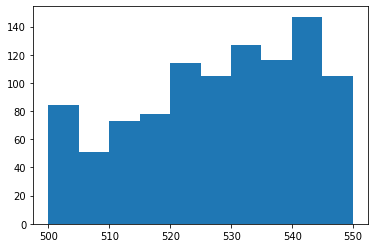

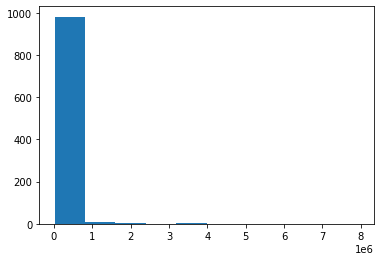

In [13]:
from vimms.ChemicalSamplers import MZMLRTandIntensitySampler
ri = MZMLRTandIntensitySampler(MZML)

rt_list = []
intensity_list = []

for i in range(1000):
    a,b = ri.sample(None) #argument is a formula, but is ignored at the moment
    rt_list.append(a)
    intensity_list.append(b)

plt.figure()
plt.hist(rt_list)
plt.figure()
plt.hist(intensity_list)

### `ChromatogramSampler`

This optional object defines where chromatograms should be sampled from for each formula. There are three options:

- `GaussianChromatogramSampler`: generates normal shape chromatographic peaks
- `ConstantChromoatogramSampler`: generates constant chromatographic (i.e. flat) peaks (mainly for testing)
- `MZMLChromatogramSampelr`: samples chromatograms from ROIs extracted from an mzML file

Note that in all cases, the `sample` method takes three arguments: a formula, an rt and an intensity. These are so that, in future we could condition the chromatogram finding on particular values of RT and intensity (e.g. high intensity = better peaks).

Examples:

#### `GaussianChomatogramSampler`

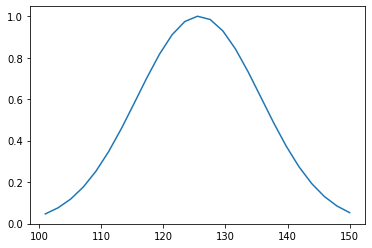

In [14]:
# grab a formula to use for example sampling
f_list = df.sample(1)
formula, name = f_list[0]
from vimms.ChemicalSamplers import GaussianChromatogramSampler
cs = GaussianChromatogramSampler(sigma=10)
example_rt = 100
example_intensity = 1e5
c = cs.sample(formula, example_rt, example_intensity)
rt_vals = np.linspace(50,150)
intensities = []
for r in rt_vals:
    intensities.append(c.get_relative_intensity(r - example_rt))
plt.plot(rt_vals, intensities)

#### `ConstantChromatogramSampler`

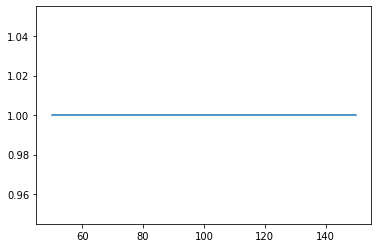

In [15]:
from vimms.ChemicalSamplers import ConstantChromatogramSampler
cs = ConstantChromatogramSampler()
example_rt = 100
example_intensity = 1e5
c = cs.sample(formula, example_rt, example_intensity)
rt_vals = np.linspace(50,150)
intensities = []
for r in rt_vals:
    intensities.append(c.get_relative_intensity(r - example_rt))
plt.plot(rt_vals, intensities)

#### `MZMLChromatogramSampler`

2022-02-24 16:34:09.710 | DEBUG    | vimms.ChemicalSamplers:_extract_rois:370 - Extracted 8119 good ROIs from C:\Users\joewa\Work\git\vimms\tests\fixtures\small_mzml.mzML


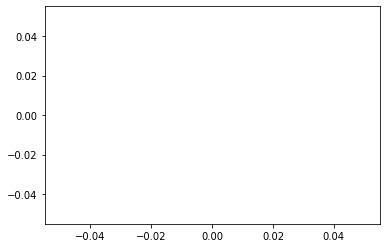

In [16]:
# note that if you want to set the parameters for the ROI extraction from the mzML, use the RioParams object
# e.g.
from vimms.Roi import RoiParams
roi_params = RoiParams(min_intensity=1000)
from vimms.ChemicalSamplers import MZMLChromatogramSampler
cs = MZMLChromatogramSampler(MZML, roi_params=roi_params)
c = cs.sample(formula, example_rt, example_intensity)
rt_vals = np.linspace(50,150)
intensities = []
for r in rt_vals:
    intensities.append(c.get_relative_intensity(r - example_rt))
plt.plot(rt_vals, intensities)

### MS2Sampler

This final class determines how chemicals will be assigned MS2 peaks. There are six options:

- `UniformMS2Sampler`: samples uniformly between a min mass and the mass of the formula
- `FixedMS2Sampler`: generates a fixed number of peaks, evenly spaced below the formula (mainly for testing)
- `CRPSMS2Sampler`: generates MS2 peaks using a Chinese Restaurant Process
- `MGFMS2Sampler`: generates MS2 spectra by sampling from those in an mgf file
- `ExactMatchMS2Sampler`: to be used in the case where objects in the MGF file share an ID with the database used for formula sampling
- `MZMLMS2Sampler`: samples MS2 spectra from an MS2 scan in an mzML file

In all cases, `sample` returns a list of masses, a list of intensties, and a *parent proportion* which is how much of the parents intensity gets transfered into the MS2 spectrum. The proportion is uniform between `min_proportion` and `max_proportion` which are passed to the constructors.

Examples:

In [17]:
def plot_spectrum(mz_list, intensity_list):
    plt.figure()
    for i,m in enumerate(mz_list):
        plt.plot([m,m],[0,intensity_list[i]])
class TempChemical:
    def __init__(self, mass):
        self.mass = mass

#### `UniformMS2Sampler`

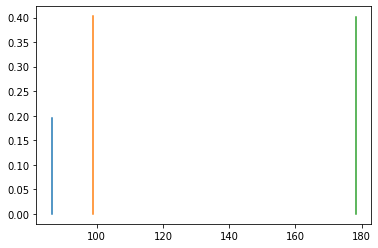

In [18]:
from vimms.ChemicalSamplers import UniformMS2Sampler
ms = UniformMS2Sampler(poiss_peak_mean=5) # number of fragments is decided by sample from poisson
tc = TempChemical(formula.mass)
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `CRPMS2Sampler`

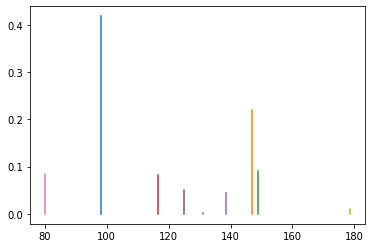

In [19]:
from vimms.ChemicalSamplers import CRPMS2Sampler
ms = CRPMS2Sampler(n_draws=500, alpha=1) # alpha and n_draws control the propery of the CRP
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `FixedMS2Sampler`

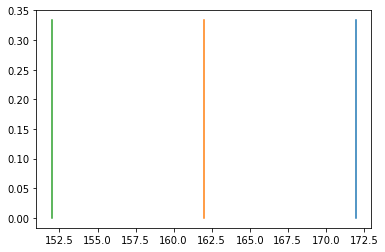

In [20]:
from vimms.ChemicalSamplers import FixedMS2Sampler
ms = FixedMS2Sampler(n_frags=3) # how many to make
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `MGFMS2Sampler`

2022-02-24 16:34:10.843 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 100 spectra
2022-02-24 16:34:10.855 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 200 spectra
2022-02-24 16:34:10.877 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 300 spectra
2022-02-24 16:34:10.959 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 400 spectra
2022-02-24 16:34:10.985 | DEBUG    | vimms.ChemicalSamplers:__init__:536 - Loaded 411 spectra from C:\Users\joewa\Work\git\vimms\tests\fixtures\small_mgf.mgf


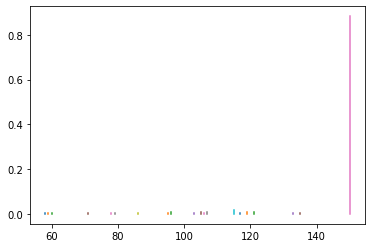

In [21]:
MGF = os.path.join(data_dir, 'small_mgf.mgf')
from vimms.ChemicalSamplers import MGFMS2Sampler
ms = MGFMS2Sampler(MGF)
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `MZMLMS2Sampler`

2022-02-24 16:34:11.559 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 364 scans
2022-02-24 16:34:11.568 | DEBUG    | vimms.ChemicalSamplers:_filter_scans:607 - 331 MS2 scansn remaining


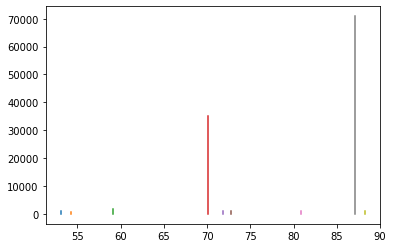

In [22]:
from vimms.ChemicalSamplers import MZMLMS2Sampler
ms = MZMLMS2Sampler(MZML)
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `ExactMatchMS2Sampler`

2022-02-24 16:34:11.759 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 100 spectra
2022-02-24 16:34:11.759 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 200 spectra
2022-02-24 16:34:11.791 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 300 spectra
2022-02-24 16:34:11.877 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 400 spectra
2022-02-24 16:34:11.897 | DEBUG    | vimms.ChemicalSamplers:__init__:536 - Loaded 411 spectra from C:\Users\joewa\Work\git\vimms\tests\fixtures\small_mgf.mgf


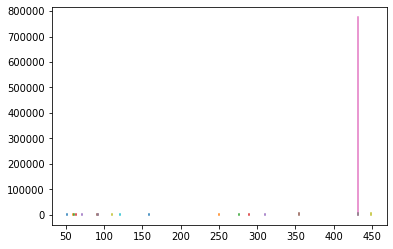

In [23]:
from vimms.ChemicalSamplers import ExactMatchMS2Sampler
# when formulas are sampled from a database, their accession is stored. We can cheat this as follows:
tc.database_accession = 'CCMSLIB00005435506'
# the MS2 sampler will then extract the spectrum that has the id_fiels set to this ID value
ms = ExactMatchMS2Sampler(MGF, id_field='SPECTRUMID')
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

## Everything together - `ChemicalMixtureCreator`

The simplest use is to just pass a formula sampler and let the rest go to defaults:

In [24]:
from vimms.Chemicals import ChemicalMixtureCreator
df = DatabaseFormulaSampler(hmdb, min_mz=100, max_mz=1000)
cm = ChemicalMixtureCreator(df)
chemicals = cm.sample(100,2) # sample 100 chemicals up to MS2

2022-02-24 16:34:18.326 | DEBUG    | vimms.ChemicalSamplers:sample:73 - 73822 unique formulas in filtered database
2022-02-24 16:34:18.332 | DEBUG    | vimms.ChemicalSamplers:sample:79 - Sampled formulas
2022-02-24 16:34:18.594 | DEBUG    | vimms.Chemicals:sample:324 - Sampled rt and intensity values and chromatograms


If more tailoring is required, pass the different samplers as arguments. E.g. if you wanted a CRPMS2Sampler and MZMLChromatograms:

In [25]:
cm = ChemicalMixtureCreator(df, ms2_sampler=CRPMS2Sampler(n_draws=100, alpha=2), chromatogram_sampler=MZMLChromatogramSampler(MZML))
chemicals = cm.sample(100,2)

2022-02-24 16:34:23.502 | DEBUG    | vimms.ChemicalSamplers:_extract_rois:370 - Extracted 8119 good ROIs from C:\Users\joewa\Work\git\vimms\tests\fixtures\small_mzml.mzML
2022-02-24 16:34:34.831 | DEBUG    | vimms.ChemicalSamplers:sample:73 - 73822 unique formulas in filtered database
2022-02-24 16:34:34.836 | DEBUG    | vimms.ChemicalSamplers:sample:79 - Sampled formulas
2022-02-24 16:34:34.900 | DEBUG    | vimms.Chemicals:sample:324 - Sampled rt and intensity values and chromatograms


### Use in simulator

We can use the sampled chemicals to simulate various fragmentation strategies in ViMMS. Below we run it through a TopN strategy.

First we set some parameters for the Top-N controller and its simulated environment.

In [26]:
rt_range = [(0, 1440)]
min_rt = rt_range[0][0]
max_rt = rt_range[0][1]

In [27]:
isolation_window = 1
N = 3
rt_tol = 15
mz_tol = 10
min_ms1_intensity = 1.75E5

Initialise simulated mass spec and the Top-N controller 

In [28]:
mass_spec = IndependentMassSpectrometer(POSITIVE, chemicals)
controller = TopNController(POSITIVE, N, isolation_window, mz_tol, rt_tol, min_ms1_intensity)

Create an environment to run both the mass spec and controller. Set the log level to WARNING so we don't see too many messages when environment is running.

In [29]:
set_log_level_warning()
env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
env.run()

  0%|          | 0/1440 [00:00<?, ?it/s]

Write the resulting mzML file from simulation to the location below. You can use ToppView from OpenMS or other mzML viewer to inspect the results. Note that the output wouldn't look very realistic as the chromatograms for all chemicals are the same (gaussian), and there's no noise or small peaks at all.

In [30]:
set_log_level_debug()
mzml_filename = 'hmdb_topn_controller_2.mzML'
out_dir = os.path.join(os.getcwd(), 'results')
env.write_mzML(out_dir, mzml_filename)

2022-02-24 16:34:52.284 | DEBUG    | vimms.Environment:write_mzML:177 - Writing mzML file to C:\Users\joewa\Work\git\vimms\demo\01. Data\results\hmdb_topn_controller_2.mzML
2022-02-24 16:34:58.192 | DEBUG    | vimms.Environment:write_mzML:181 - mzML file successfully written!
